# Heart Attack Risk Classification

Build and compare **5 classification models** to predict **Heart Attack Risk** using the dataset in `data/heart_attack_prediction_dataset.csv`.

## A→Z TODO List (Project Checklist)
- [ ] **A**cquire data (load CSV)
- [ ] **B**rowse columns + dtypes
- [ ] **C**hoose target (`Heart Attack Risk`) and define task
- [ ] **D**etect missing values + duplicates
- [ ] **E**xtract/engineer features (parse `Blood Pressure` → systolic/diastolic)
- [ ] **F**lag invalid values/outliers (sanity checks)
- [ ] **G**raph target distribution and imbalance
- [ ] **H**istograms for numeric features
- [ ] **I**nspect categorical distributions (count plots)
- [ ] **J**oint relationships (correlations + feature vs target)
- [ ] **K**eep preprocessing reproducible with sklearn Pipelines
- [ ] **L**Label encode/one-hot encode categoricals
- [ ] **M**ake 5 models and compare
- [ ] **N**ote best model + metrics
- [ ] **O**btain confusion matrix + ROC/PR curves
- [ ] **P**Permutation importance for best model
- [ ] **Q**(Optional) quick tuning
- [ ] **R**Review results + limitations
- [ ] **S**Save best pipeline (`joblib`)

In [95]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import loguniform

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.inspection import permutation_importance

import joblib

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

In [96]:
DATA_PATH = 'data/heart_attack_prediction_dataset.csv'
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head()

Shape: (8763, 26)


,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [97]:
missing = df.isna().sum().sort_values(ascending=False)
print('Missing (top 15):')
display(missing.head(15))

print('Duplicates:', int(df.duplicated().sum()))

display(df.describe(include='all').T.head(30))

Missing (top 15):


Patient ID                         0
Age                                0
Hemisphere                         0
Continent                          0
Country                            0
Sleep Hours Per Day                0
Physical Activity Days Per Week    0
Triglycerides                      0
BMI                                0
Income                             0
Sedentary Hours Per Day            0
Stress Level                       0
Medication Use                     0
Previous Heart Problems            0
Diet                               0
dtype: int64

Duplicates: 0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Patient ID,8763,8763,BMW7812,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,8763.0,NaN,NaN,NaN,53.707977,21.249509,18.0,35.0,54.0,72.0,90.0
Sex,8763,2,Male,6111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cholesterol,8763.0,NaN,NaN,NaN,259.877211,80.863276,120.0,192.0,259.0,330.0,400.0
Blood Pressure,8763,3915,146/94,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heart Rate,8763.0,NaN,NaN,NaN,75.021682,20.550948,40.0,57.0,75.0,93.0,110.0
Diabetes,8763.0,NaN,NaN,NaN,0.652288,0.476271,0.0,0.0,1.0,1.0,1.0
Family History,8763.0,NaN,NaN,NaN,0.492982,0.499979,0.0,0.0,0.0,1.0,1.0
Smoking,8763.0,NaN,NaN,NaN,0.896839,0.304186,0.0,1.0,1.0,1.0,1.0
Obesity,8763.0,NaN,NaN,NaN,0.501426,0.500026,0.0,0.0,1.0,1.0,1.0


## Feature Plan
- Target: `Heart Attack Risk` (0/1)
- Drop: `Patient ID` (identifier only)
- Engineer: parse `Blood Pressure` like `158/88` into `BP_Systolic` and `BP_Diastolic`

In [98]:
df_model = df.copy()

if 'Patient ID' in df_model.columns:
    df_model = df_model.drop(columns=['Patient ID'])

if 'Blood Pressure' in df_model.columns:
    bp = df_model['Blood Pressure'].astype(str).str.split('/', expand=True)
    df_model['BP_Systolic'] = pd.to_numeric(bp[0], errors='coerce')
    df_model['BP_Diastolic'] = pd.to_numeric(bp[1], errors='coerce')
    df_model = df_model.drop(columns=['Blood Pressure'])

TARGET = 'Heart Attack Risk'
assert TARGET in df_model.columns

X = df_model.drop(columns=[TARGET])
y = df_model[TARGET].astype(int)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print('Numeric:', len(numeric_features), numeric_features)
print('Categorical:', len(categorical_features), categorical_features)
df_model.head()

Numeric: 20 ['Age', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'BP_Systolic', 'BP_Diastolic']
Categorical: 5 ['Sex', 'Diet', 'Country', 'Continent', 'Hemisphere']


,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk,BP_Systolic,BP_Diastolic
0,67,Male,208,72,0,0,1,0,0,4.168189,...,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0,158,88
1,21,Male,389,98,1,1,1,1,1,1.813242,...,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0,165,93
2,21,Female,324,72,1,0,0,0,0,2.078353,...,28.176571,587,4,4,France,Europe,Northern Hemisphere,0,174,99
3,84,Male,383,73,1,1,1,0,1,9.828130,...,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0,163,100
4,66,Male,318,93,1,1,1,1,0,5.804299,...,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0,91,88


## Early Feature Ranking (Before Modeling)

These are **quick, model-free** signals to understand which features relate most to the target *before* training any classifier:


- **Numeric correlation with target** (Pearson / point-biserial for binary targets)

- **Mutual information** (captures non-linear relationships; works for numeric + one-hot encoded categoricals)


Cholesterol                        0.019340
BP_Systolic                        0.018585
Sleep Hours Per Day               -0.018528
Diabetes                           0.017225
Alcohol Consumption               -0.013778
Obesity                           -0.013318
Exercise Hours Per Week            0.011133
Triglycerides                      0.010471
Income                             0.009628
BP_Diastolic                      -0.007509
Age                                0.006403
Sedentary Hours Per Day           -0.005613
Physical Activity Days Per Week   -0.005014
Heart Rate                        -0.004251
Stress Level                      -0.004111
Smoking                           -0.004051
Medication Use                     0.002234
Family History                    -0.001652
Previous Heart Problems            0.000274
BMI                                0.000020
dtype: float64

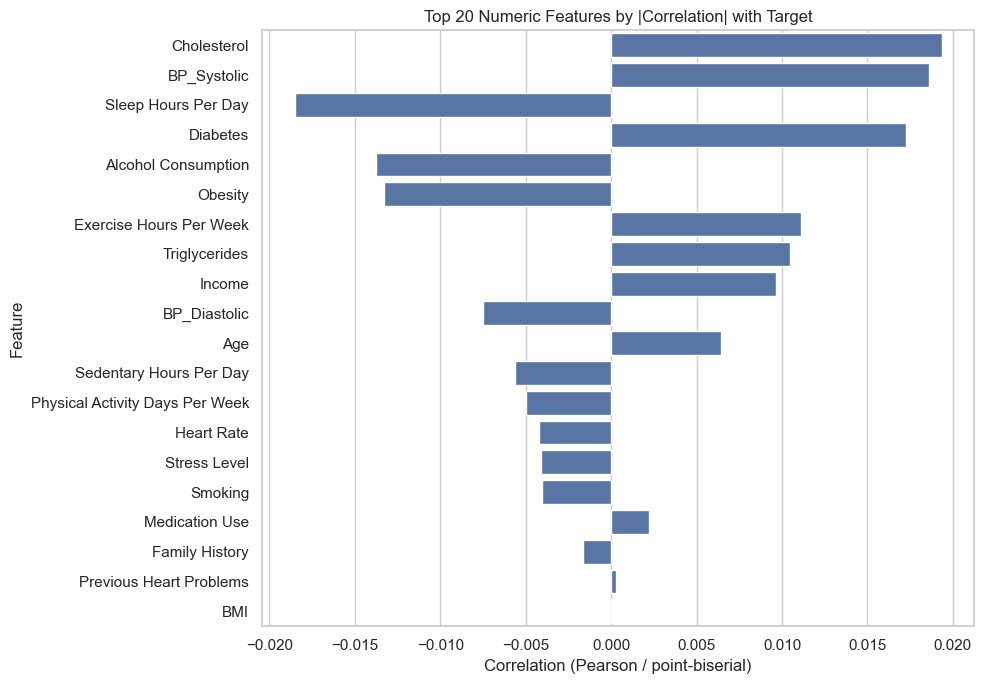

cat__Diet_Unhealthy                     0.009211
cat__Sex_Male                           0.007818
num__Family History                     0.007580
cat__Country_India                      0.006902
cat__Diet_Healthy                       0.006760
num__BP_Systolic                        0.006575
num__Age                                0.006248
cat__Diet_Average                       0.006018
num__BMI                                0.004761
num__Exercise Hours Per Week            0.004590
num__Income                             0.004469
num__Physical Activity Days Per Week    0.004208
cat__Continent_Africa                   0.003709
num__Previous Heart Problems            0.003541
cat__Country_Argentina                  0.003268
cat__Continent_Europe                   0.003227
cat__Country_France                     0.003106
cat__Continent_South America            0.002744
cat__Hemisphere_Northern Hemisphere     0.002327
cat__Country_China                      0.002210
num__Heart Rate     

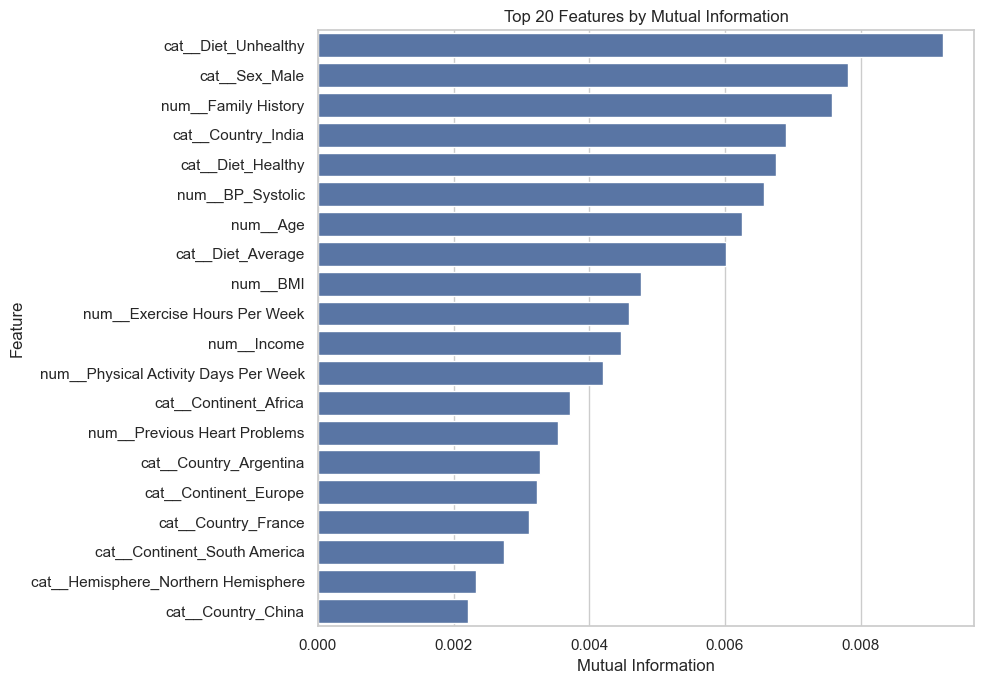

In [99]:
from sklearn.feature_selection import mutual_info_classif

# 1) Numeric correlations with target (point-biserial == Pearson with 0/1 target)
num_corr = pd.Series(index=numeric_features, dtype=float)
for col in numeric_features:
    num_corr[col] = np.corrcoef(X[col].to_numpy(), y.to_numpy())[0, 1]
num_corr = num_corr.sort_values(key=lambda s: s.abs(), ascending=False)
display(num_corr.head(20))

plt.figure(figsize=(10, 7))
sns.barplot(x=num_corr.head(20).values, y=num_corr.head(20).index)
plt.title('Top 20 Numeric Features by |Correlation| with Target')
plt.xlabel('Correlation (Pearson / point-biserial)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 2) Mutual information on a lightweight preprocessed matrix (impute + one-hot; no scaling needed for MI)
mi_preprocess = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features),
    ]
)

X_mi = mi_preprocess.fit_transform(X)
mi = mutual_info_classif(X_mi, y, random_state=42)

if hasattr(mi_preprocess, 'get_feature_names_out'):
    mi_names = mi_preprocess.get_feature_names_out()
else:
    mi_names = np.array([f'feature_{i}' for i in range(X_mi.shape[1])])

mi_s = pd.Series(mi, index=mi_names).sort_values(ascending=False)
display(mi_s.head(25))

plt.figure(figsize=(10, 7))
sns.barplot(x=mi_s.head(20).values, y=mi_s.head(20).index)
plt.title('Top 20 Features by Mutual Information')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## EDA
This section generates graphs for the target and for all features.

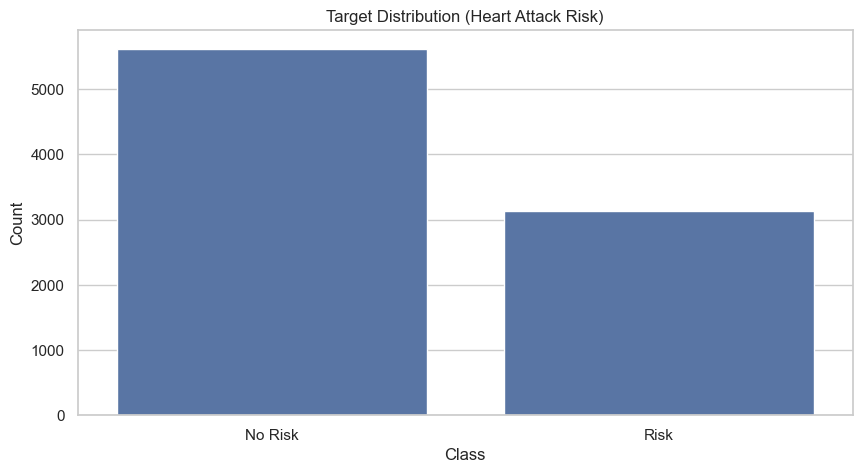

Heart Attack Risk
0    5624
1    3139
Name: count, dtype: int64

Heart Attack Risk
0    0.641789
1    0.358211
Name: proportion, dtype: float64

In [100]:
ax = sns.countplot(x=y.map({0: 'No Risk', 1: 'Risk'}))
ax.set_title('Target Distribution (Heart Attack Risk)')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.show()

display(y.value_counts())
display(y.value_counts(normalize=True).rename('proportion'))

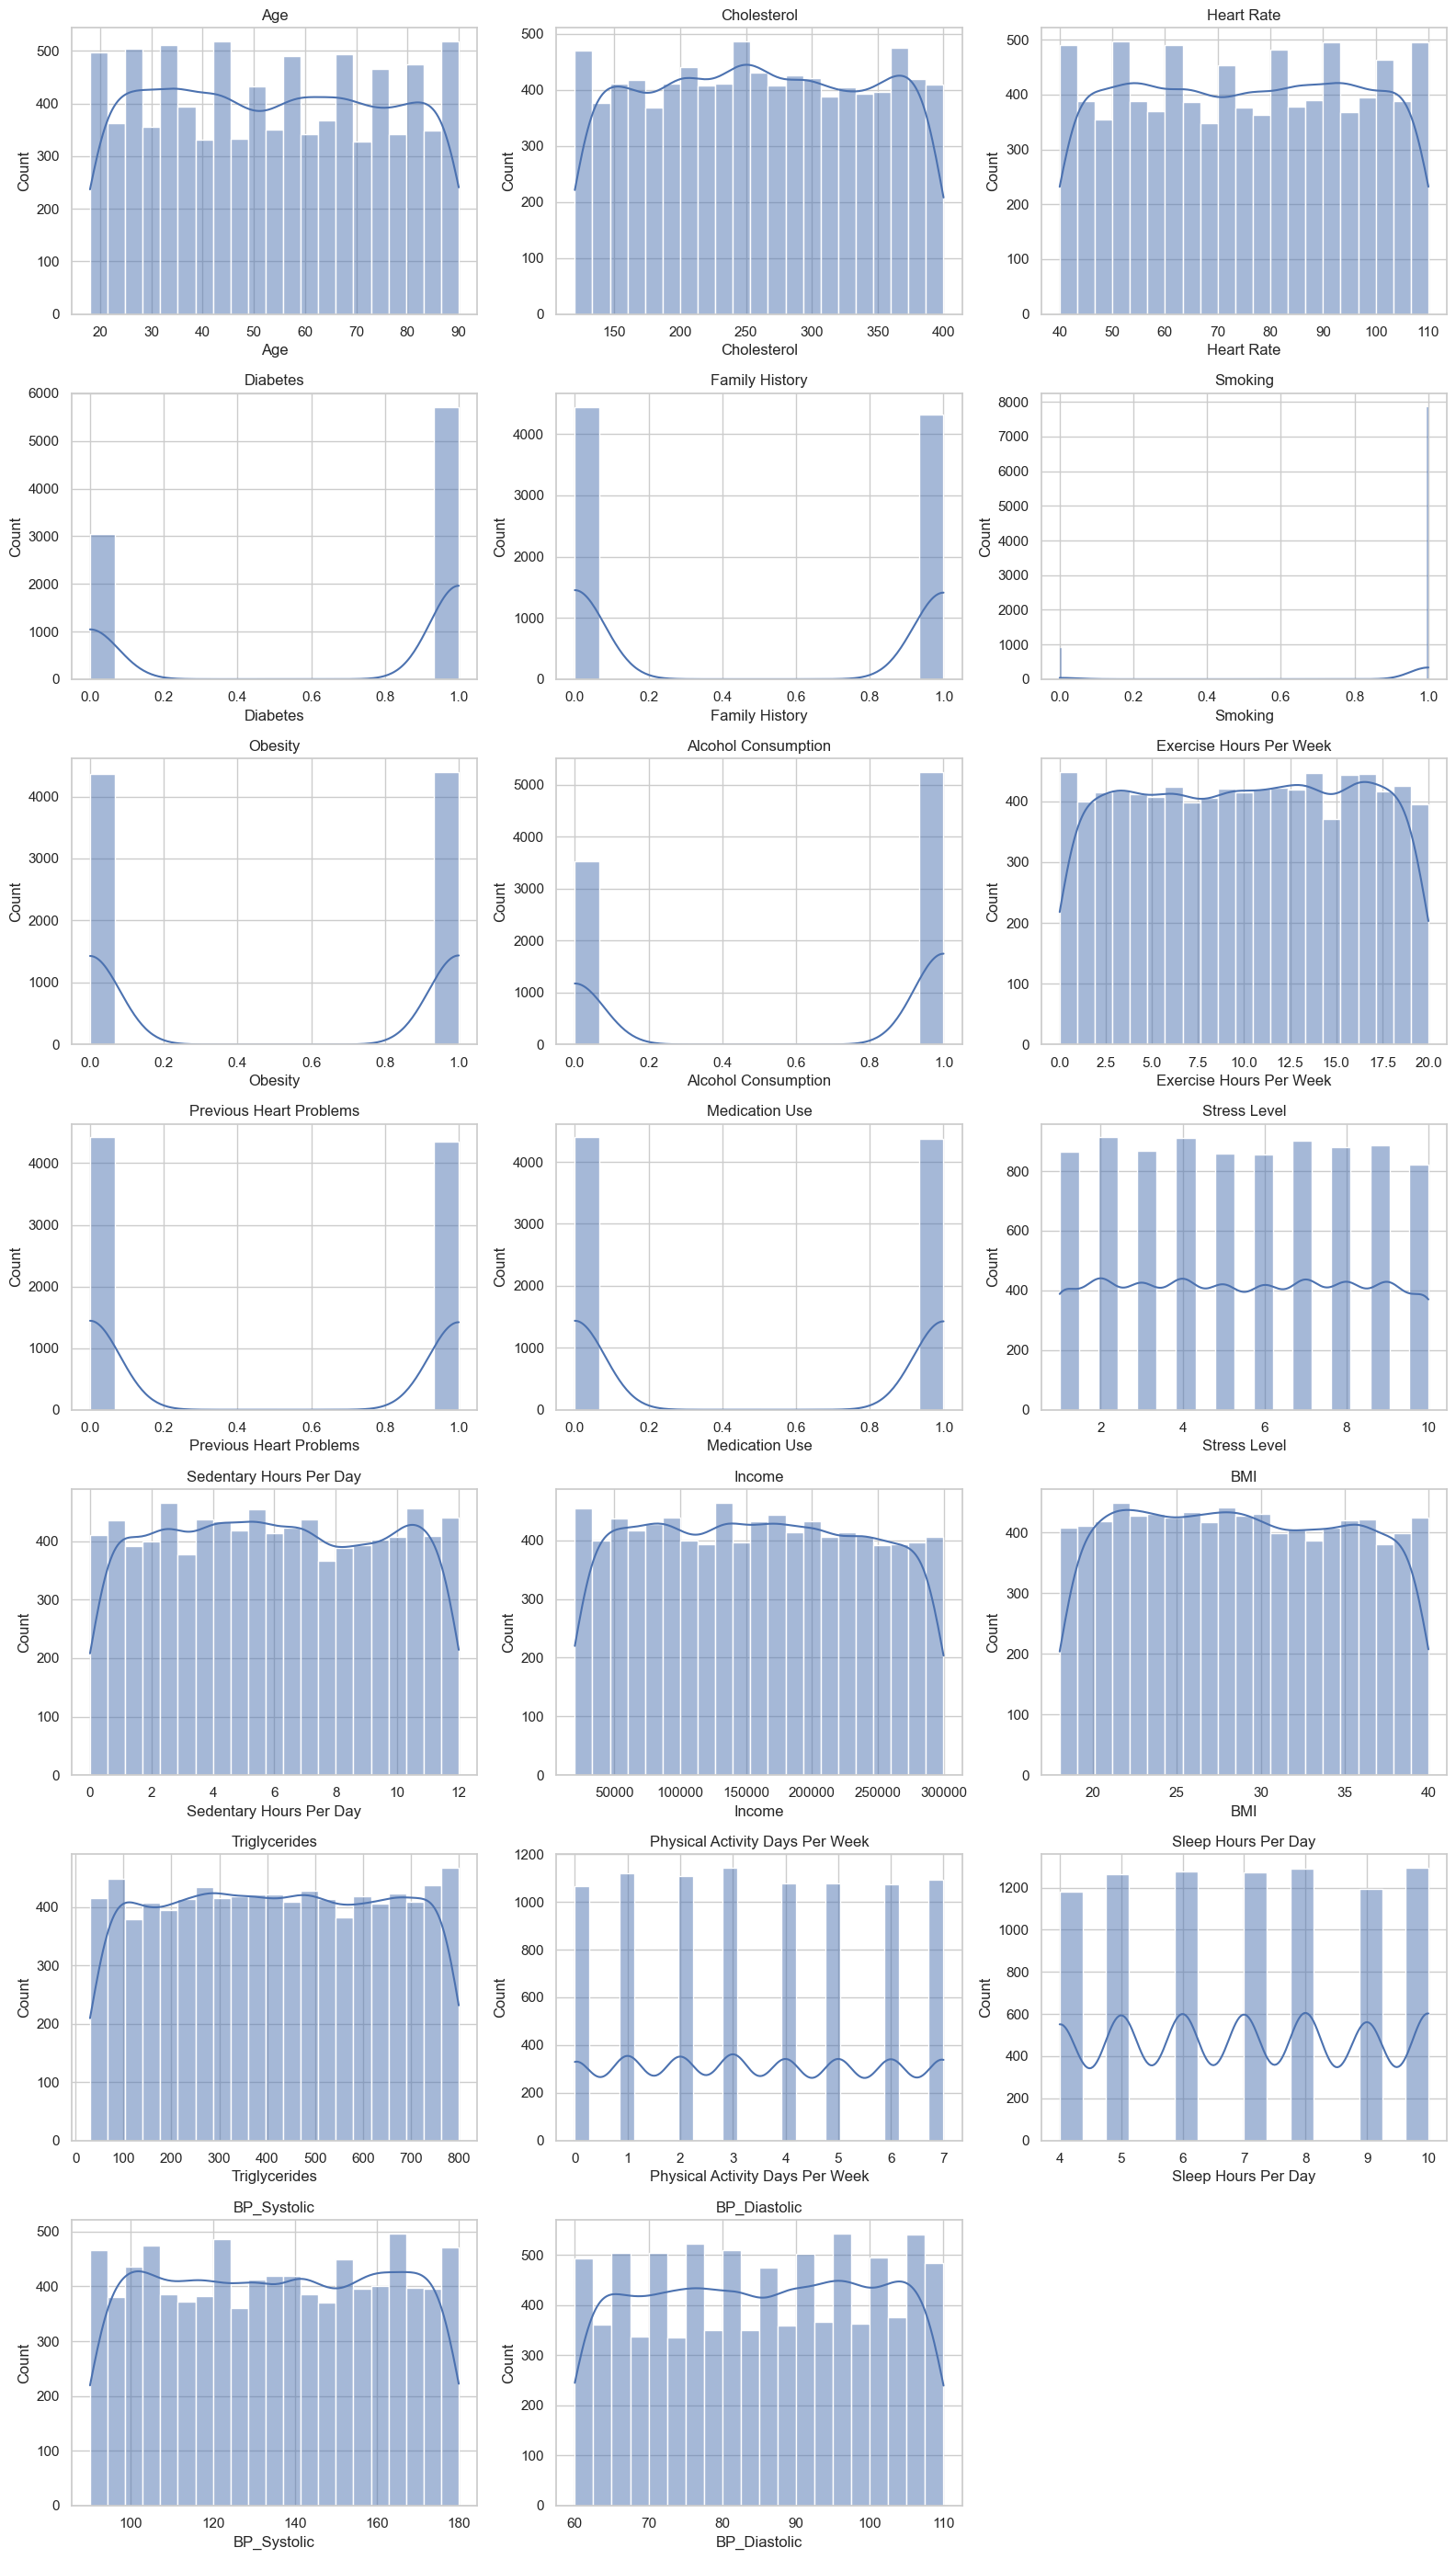

In [101]:
n = len(numeric_features)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axes = np.array(axes).reshape(-1)

for i, col in enumerate(numeric_features):
    ax = axes[i]
    sns.histplot(df_model[col], kde=True, ax=ax)
    ax.set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

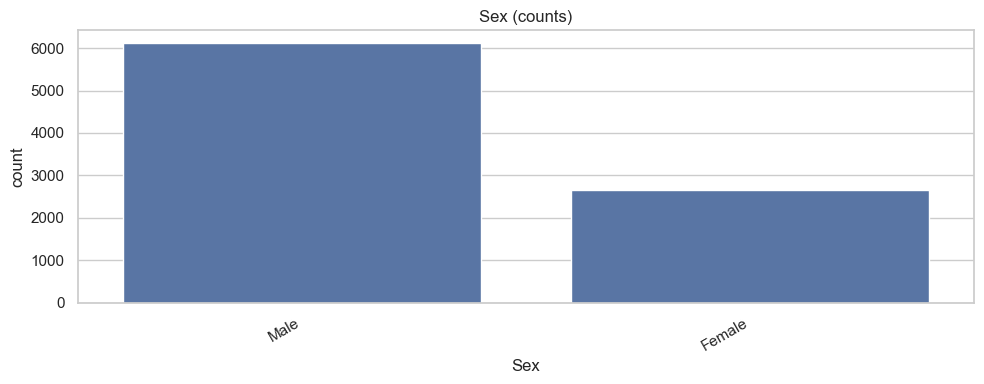

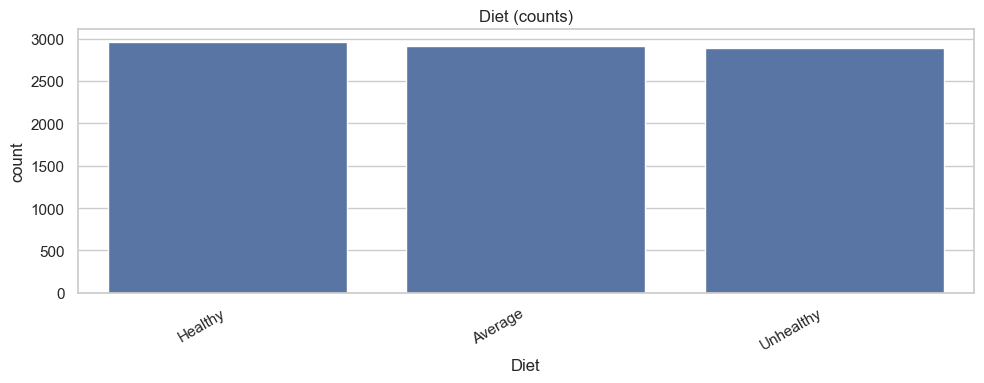

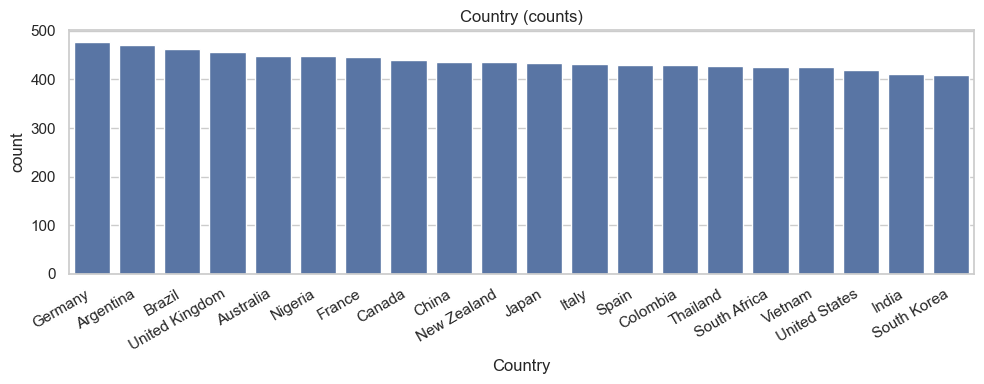

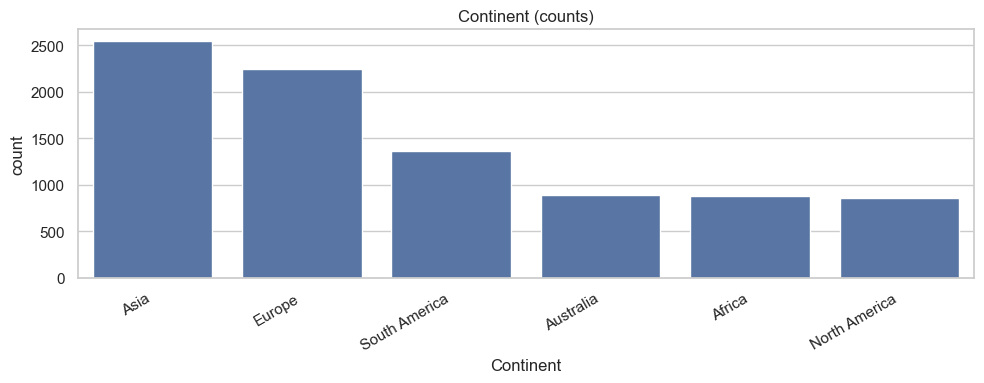

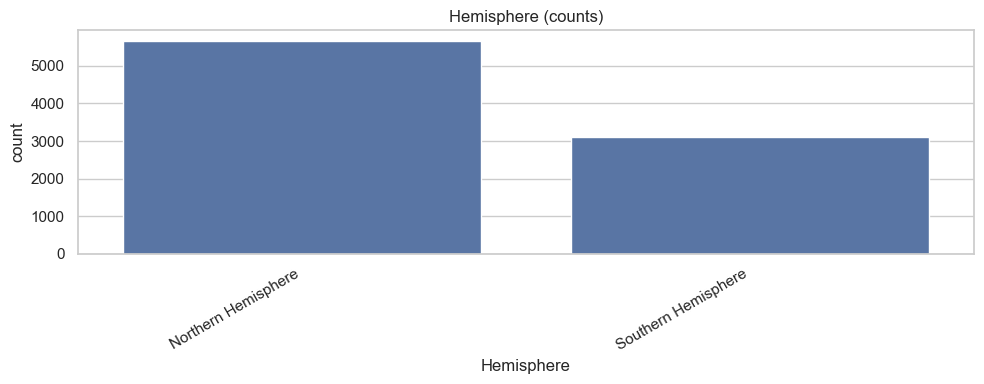

In [102]:
for col in categorical_features:
    plt.figure(figsize=(10, 4))
    order = df_model[col].value_counts().index
    sns.countplot(data=df_model, x=col, order=order)
    plt.title(f'{col} (counts)')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

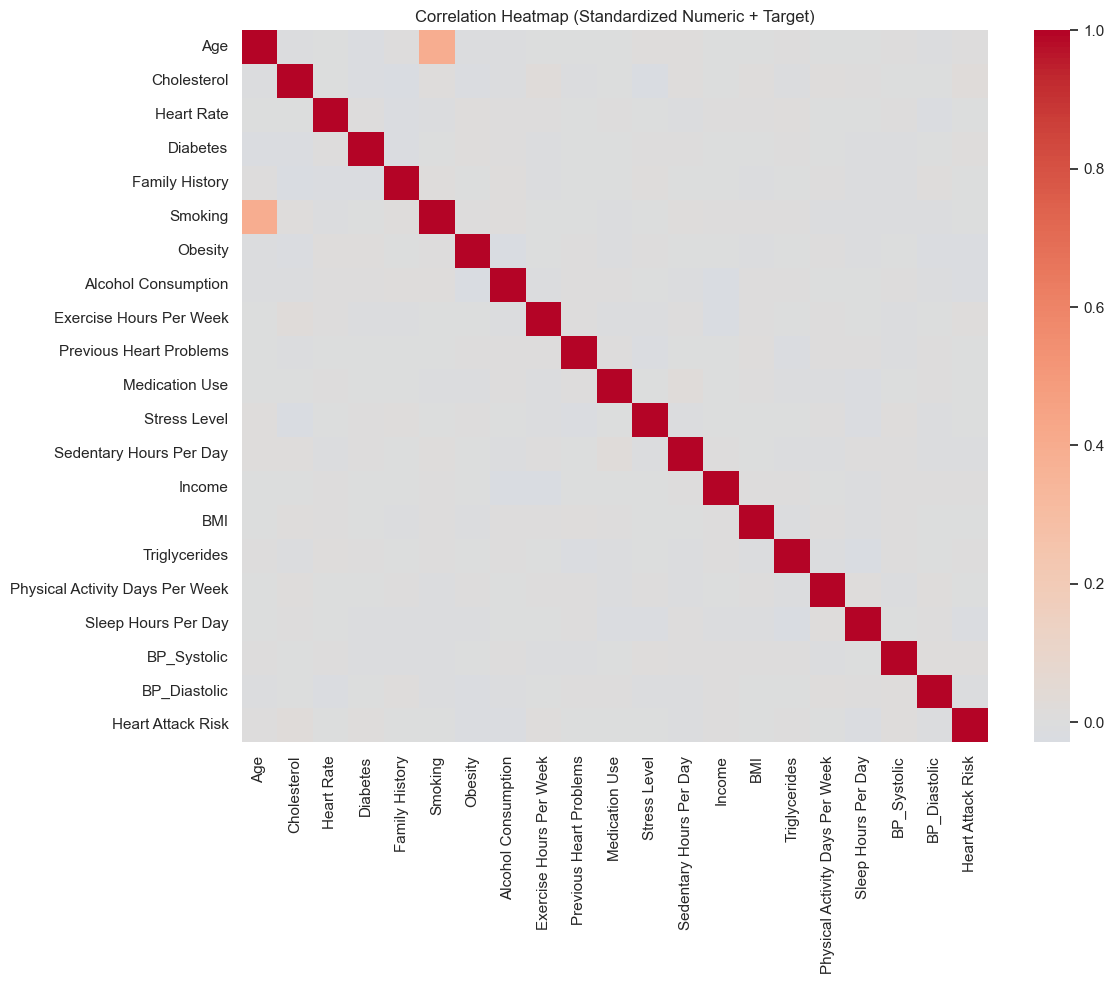

In [103]:
# Correlation Heatmap (standardized numeric features)
scaler_for_eda = StandardScaler()
X_num_scaled = pd.DataFrame(
    scaler_for_eda.fit_transform(df_model[numeric_features]),
    columns=numeric_features,
    index=df_model.index,
 )

# Correlation is scale-invariant, but standardizing helps avoid any downstream plotting surprises
corr = pd.concat([X_num_scaled, y.rename(TARGET)], axis=1).corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, square=False)
plt.title('Correlation Heatmap (Standardized Numeric + Target)')
plt.tight_layout()
plt.show()

In [104]:
# Sanity-check: confirm numeric features are standardized (mean≈0, std≈1)
means = X_num_scaled.mean().abs().sort_values(ascending=False)
stds = (X_num_scaled.std(ddof=0) - 1).abs().sort_values(ascending=False)
print('Max |mean|:', float(means.iloc[0]))
print('Max |std-1|:', float(stds.iloc[0]))
display(pd.DataFrame({'abs_mean': means.head(10), 'abs_std_minus_1': stds.head(10)}))

print('Note: Pearson correlation is scale-invariant — normalization will not create correlation;')
print('a near-zero heatmap just means weak *linear* relationships in this dataset.')

Max |mean|: 3.308244165127478e-16
Max |std-1|: 2.220446049250313e-16


,abs_mean,abs_std_minus_1
Alcohol Consumption,1.029772e-16,NaN
BMI,1.808182e-16,1.110223e-16
BP_Diastolic,3.142021e-16,NaN
BP_Systolic,3.308244e-16,0.000000e+00
Diabetes,NaN,2.220446e-16
Exercise Hours Per Week,1.208158e-16,NaN
Family History,NaN,1.110223e-16
Heart Rate,1.791966e-16,NaN
Income,1.629797e-16,NaN
Medication Use,1.240592e-16,1.110223e-16


Note: Pearson correlation is scale-invariant — normalization will not create correlation;
a near-zero heatmap just means weak *linear* relationships in this dataset.


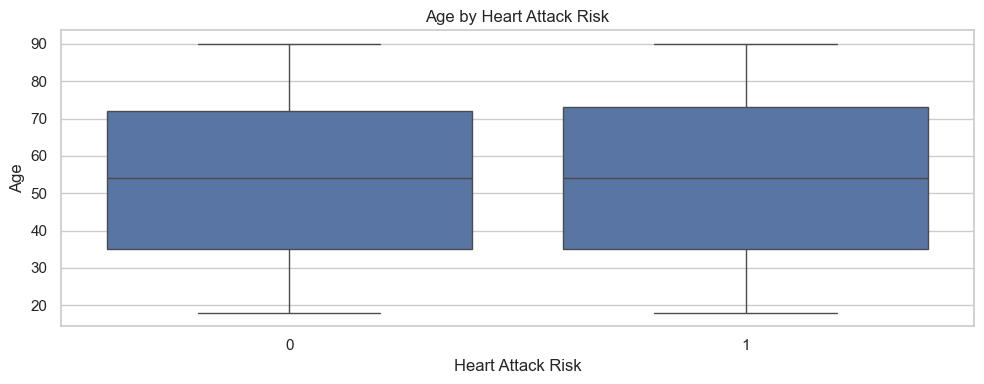

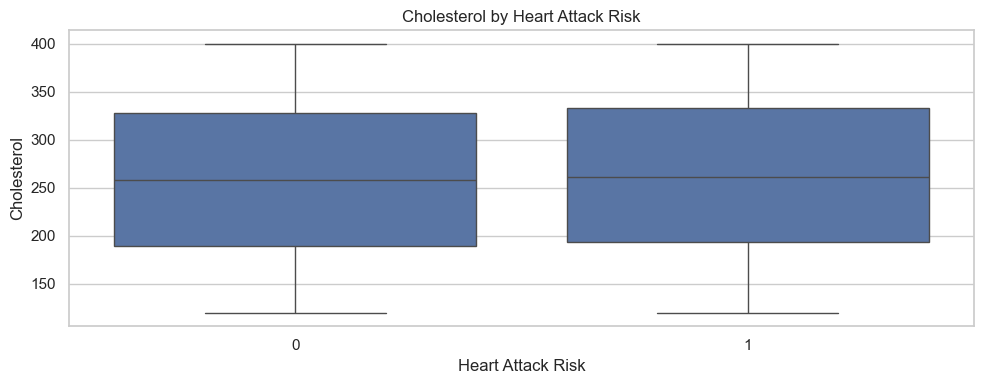

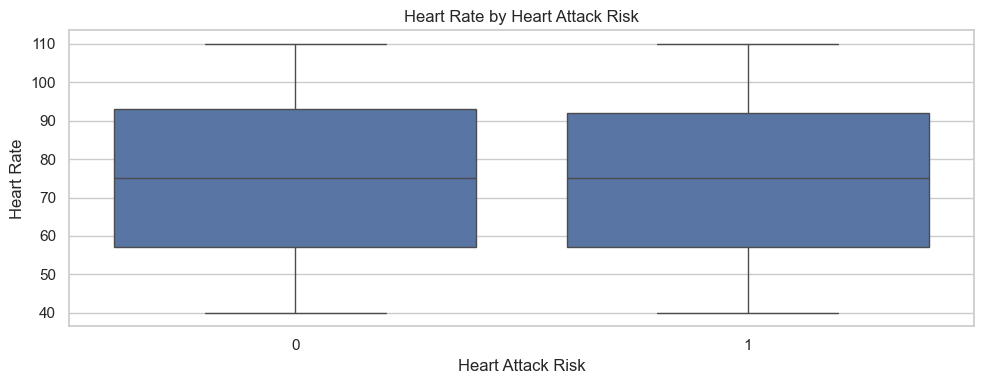

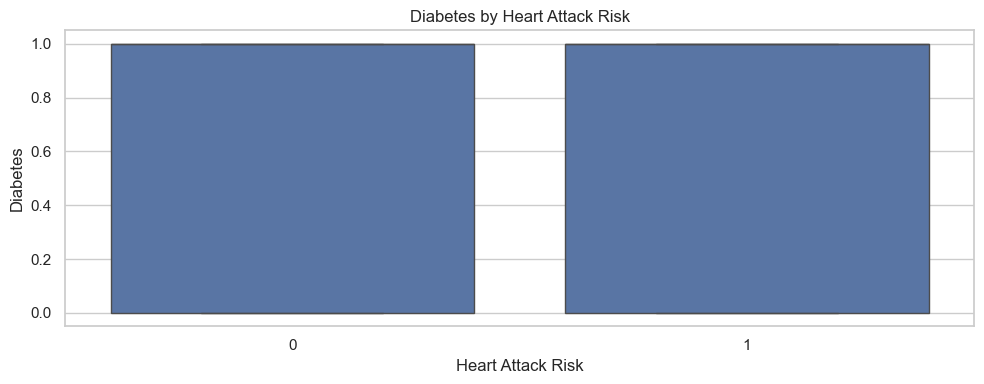

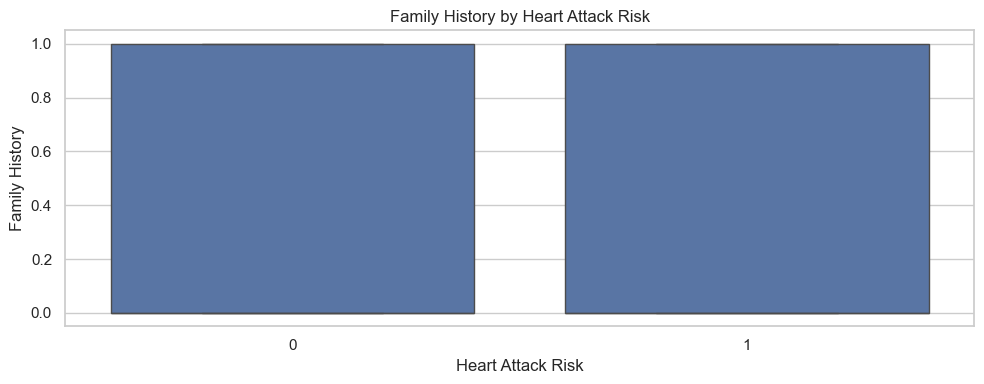

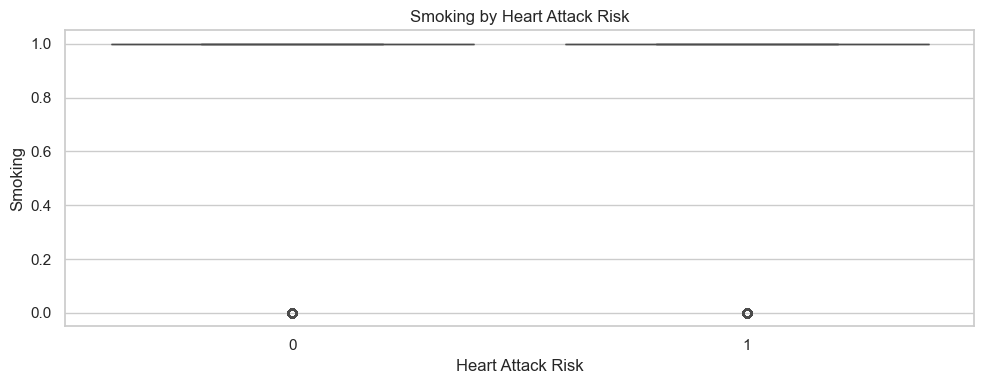

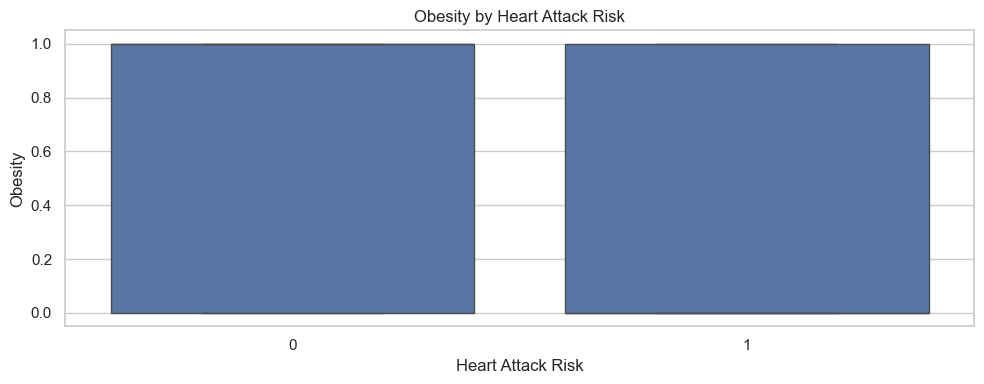

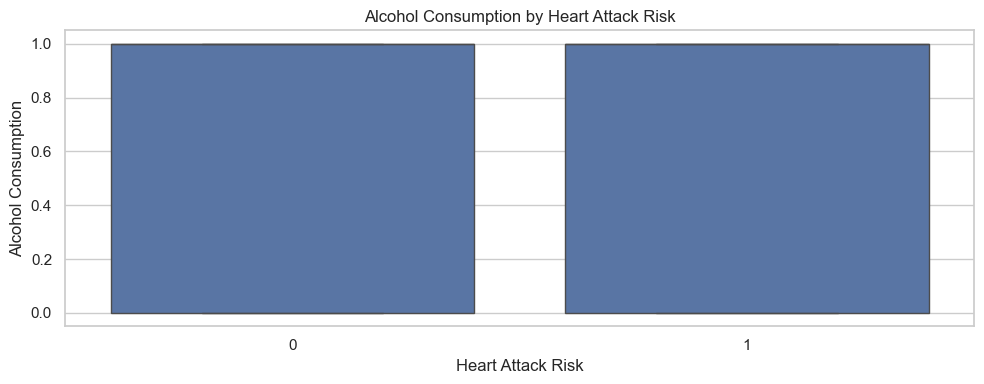

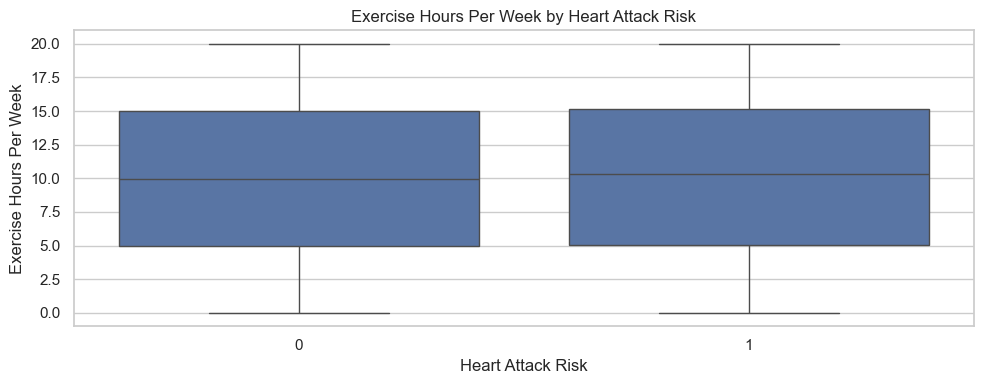

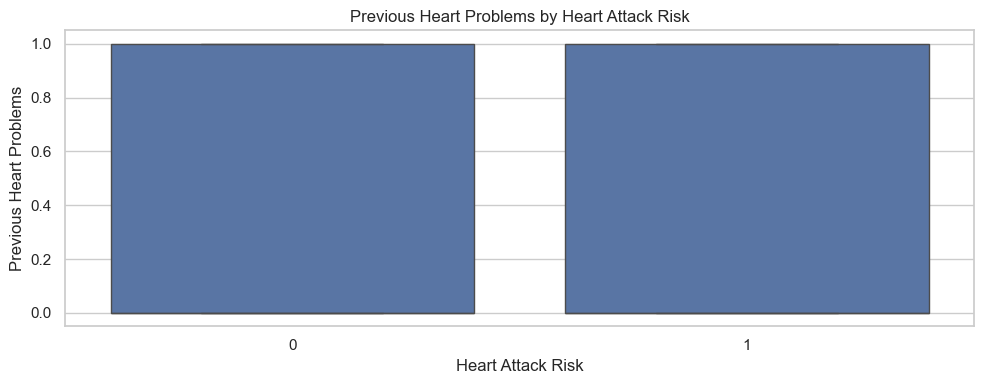

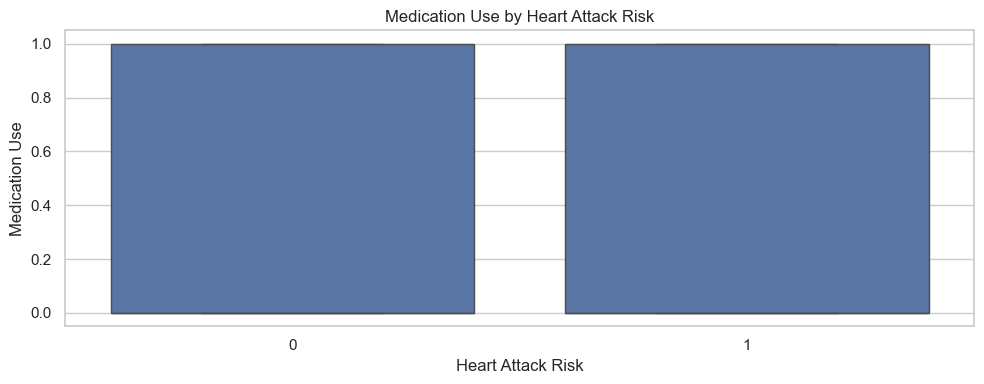

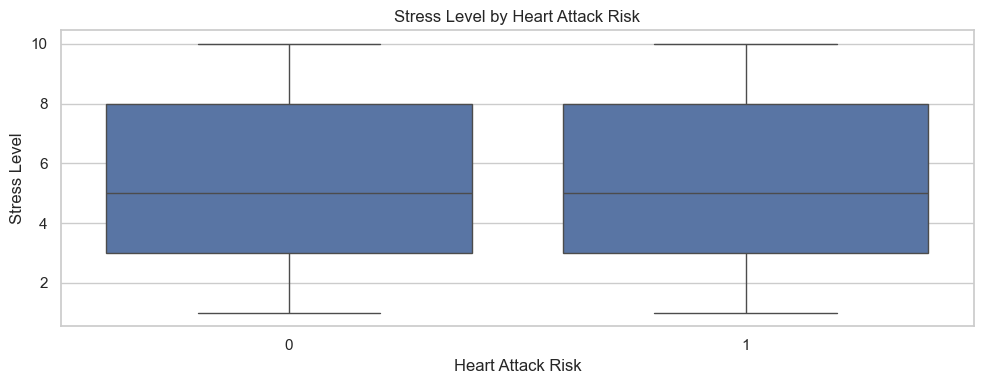

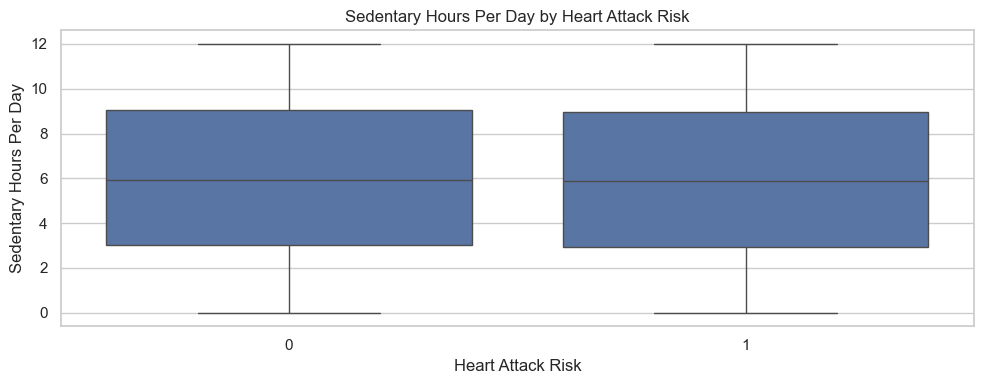

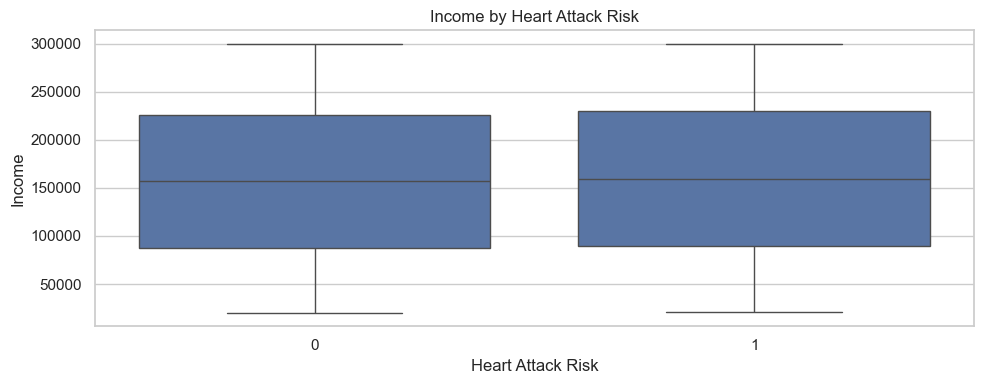

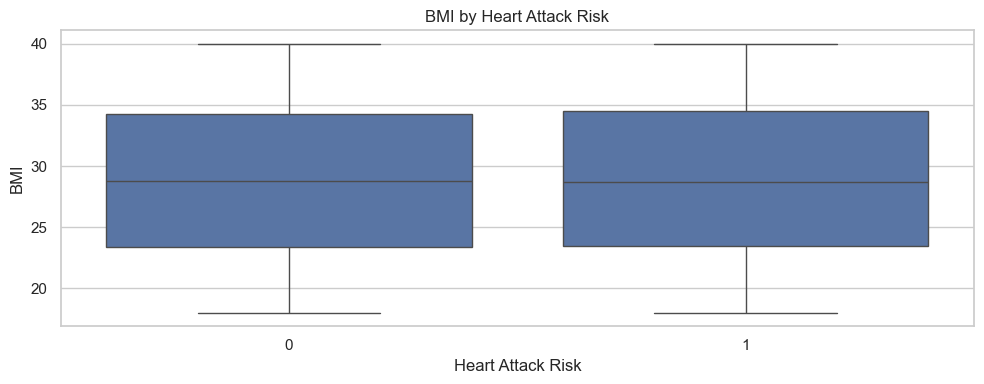

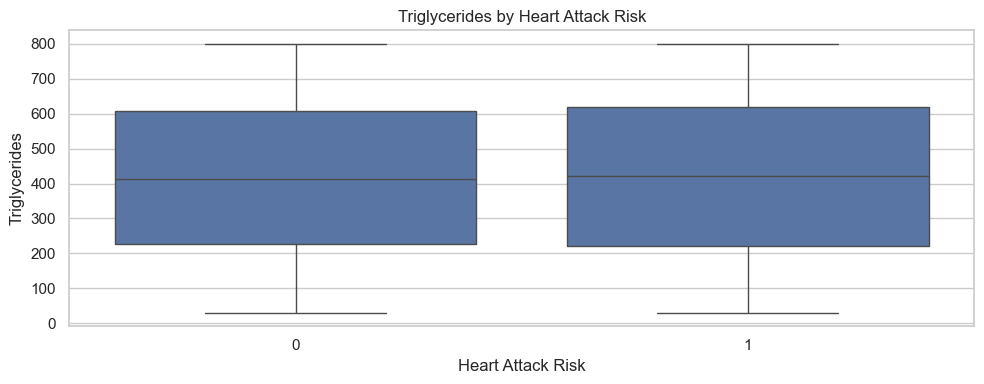

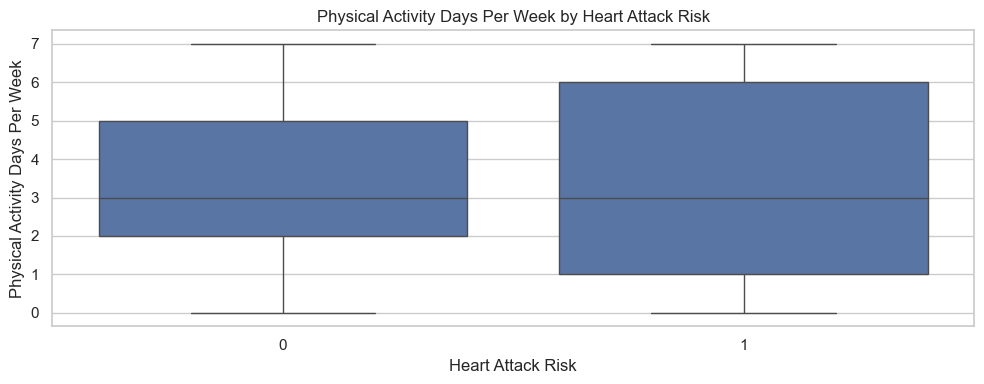

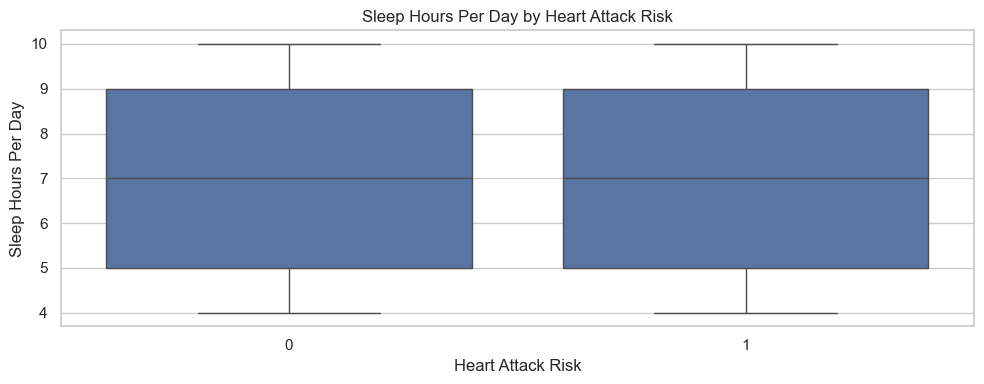

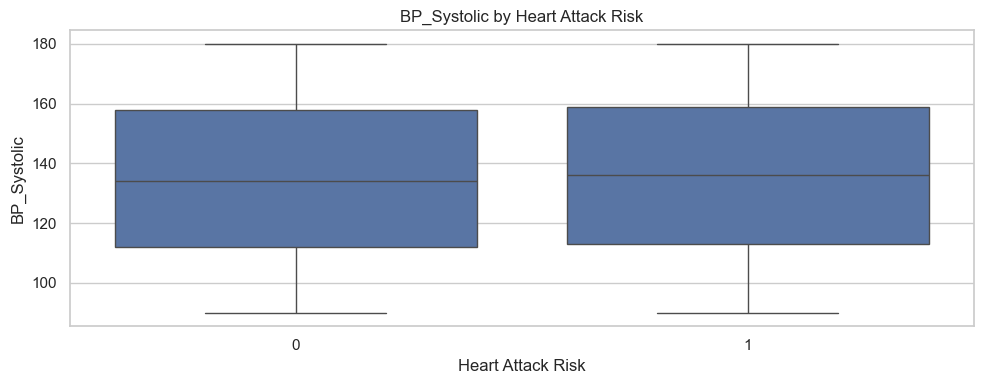

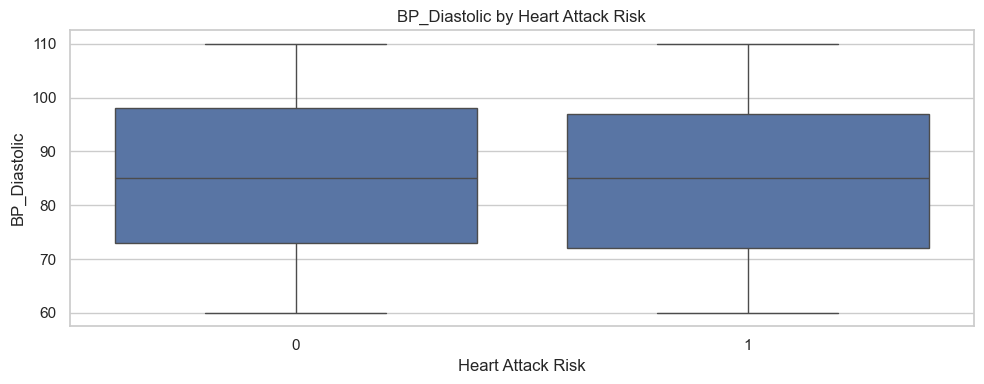

In [105]:
for col in numeric_features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df_model, x=TARGET, y=col)
    plt.title(f'{col} by {TARGET}')
    plt.tight_layout()
    plt.show()

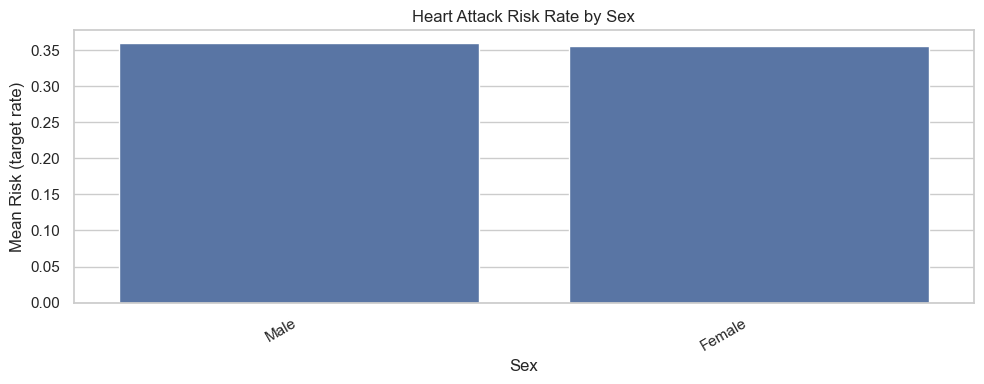

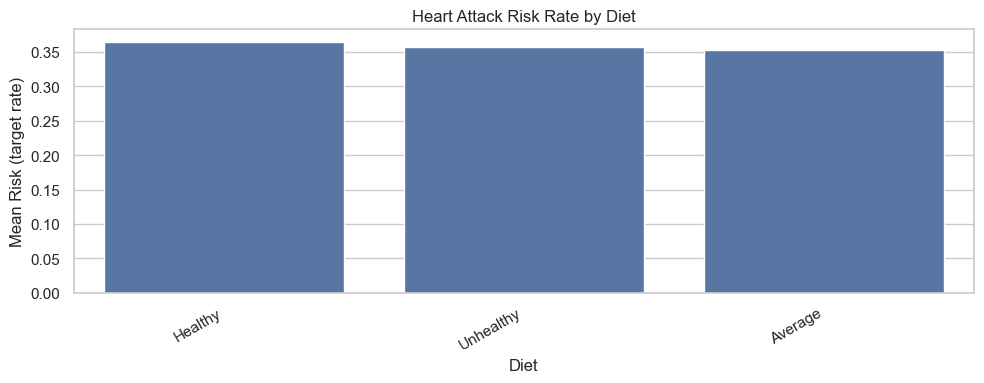

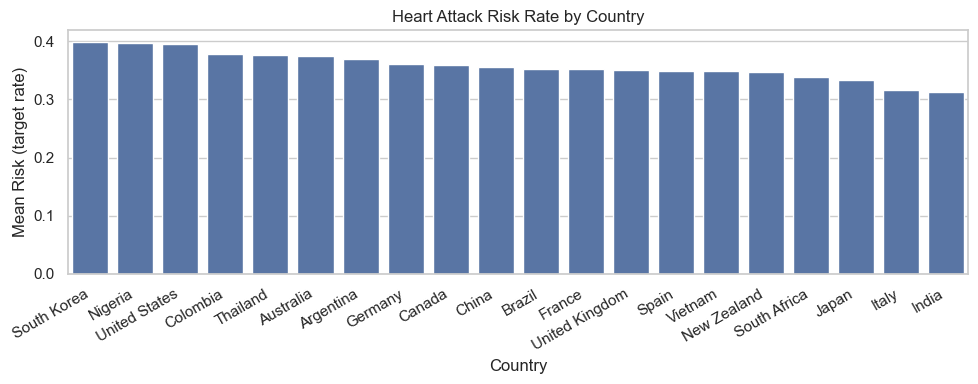

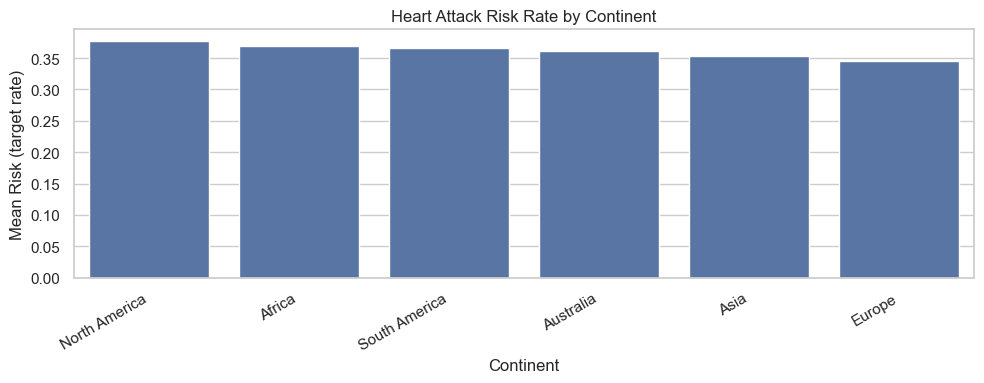

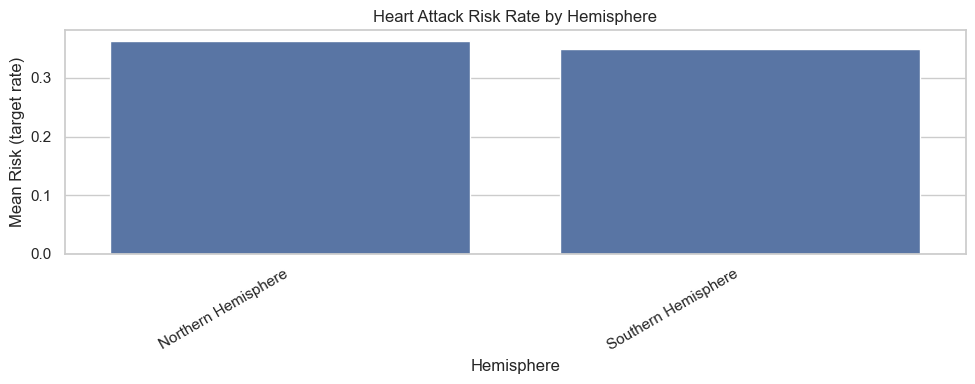

In [106]:
for col in categorical_features:
    rate = df_model.groupby(col)[TARGET].mean().sort_values(ascending=False)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=rate.index.astype(str), y=rate.values)
    plt.title(f'Heart Attack Risk Rate by {col}')
    plt.ylabel('Mean Risk (target rate)')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

## Modeling (5 Models)
We use a single preprocessing pipeline (impute + scale numeric, impute + one-hot categorical), then compare 5 classifiers.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

def evaluate(pipe, name):
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, 'predict_proba') else None

    out = {
        'model': name,
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds, zero_division=0),
        'recall': recall_score(y_test, preds, zero_division=0),
        'f1': f1_score(y_test, preds, zero_division=0),
    }
    if proba is not None:
        out['roc_auc'] = roc_auc_score(y_test, proba)
    else:
        out['roc_auc'] = np.nan
    return out, preds, proba

def show_curves(name, proba):
    if proba is None:
        print(f'{name}: no probabilities available for ROC/PR curves')
        return
    RocCurveDisplay.from_predictions(y_test, proba)
    plt.title(f'{name} - ROC Curve')
    plt.show()
    PrecisionRecallDisplay.from_predictions(y_test, proba)
    plt.title(f'{name} - Precision-Recall Curve')
    plt.show()

In [108]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=3000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, class_weight='balanced_subsample'),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=25),
}

results = []
fitted = {}
pred_store = {}
proba_store = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', clf)])
    res, preds, proba = evaluate(pipe, name)
    results.append(res)
    fitted[name] = pipe
    pred_store[name] = preds
    proba_store[name] = proba

results_df = pd.DataFrame(results).sort_values(by=['roc_auc', 'f1'], ascending=False)
display(results_df)
best_name = results_df.iloc[0]['model']
print('Best model:', best_name)

,model,accuracy,precision,recall,f1,roc_auc
3,HistGradientBoosting,0.633200,0.446043,0.098726,0.161669,0.529740
1,RandomForest,0.641187,0.000000,0.000000,0.000000,0.515854
2,GradientBoosting,0.637193,0.388889,0.022293,0.042169,0.512065
0,LogisticRegression,0.507131,0.362471,0.495223,0.418573,0.506423
4,KNN,0.622932,0.363636,0.070064,0.117490,0.491090


Best model: HistGradientBoosting


## Improve Accuracy: Feature Reduction + Proper Tuning (No Leakage)

Your current best accuracy (~0.63–0.64) is close to the **majority-class baseline** (~0.64).
To improve *properly*, we’ll tune a model **inside cross-validation** and use **feature reduction** via L1 / ElasticNet regularization (sparse coefficients).

In [109]:
# Baseline: majority-class accuracy on the same test split
majority_class = int(y_train.value_counts().idxmax())
baseline_test_acc = float((y_test == majority_class).mean())
print('Majority-class baseline test accuracy:', baseline_test_acc)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def tune_and_eval(pipe, param_distributions, label, n_iter=35):
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1,
        random_state=42,
        verbose=0,
        refit=True,
    )
    search.fit(X_train, y_train)
    best_pipe = search.best_estimator_
    preds = best_pipe.predict(X_test)
    proba = best_pipe.predict_proba(X_test)[:, 1] if hasattr(best_pipe, 'predict_proba') else None
    metrics = {
        'model': label,
        'cv_accuracy': float(search.best_score_),
        'test_accuracy': float(accuracy_score(y_test, preds)),
        'precision': float(precision_score(y_test, preds, zero_division=0)),
        'recall': float(recall_score(y_test, preds, zero_division=0)),
        'f1': float(f1_score(y_test, preds, zero_division=0)),
        'roc_auc': float(roc_auc_score(y_test, proba)) if proba is not None else np.nan,
        'best_params': search.best_params_,
    }
    return best_pipe, preds, proba, metrics

# Feature reduction option 1: L1/ElasticNet Logistic Regression (sparse coefficients)
lr_base = LogisticRegression(solver='saga', max_iter=12000, n_jobs=-1)
lr_pipe_full = Pipeline(steps=[('preprocess', preprocess), ('model', lr_base)])
lr_params = {
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__C': loguniform(1e-3, 1e2),
    'model__class_weight': [None, 'balanced'],
    'model__l1_ratio': np.linspace(0.05, 0.95, 10),
}

# Feature reduction option 2: drop high-cardinality 'Country' (often noisy in this dataset)
categorical_features_reduced = [c for c in categorical_features if c != 'Country']
preprocess_reduced = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features_reduced),
    ]
)
lr_pipe_reduced = Pipeline(steps=[('preprocess', preprocess_reduced), ('model', lr_base)])

# Stronger non-linear option: HistGradientBoosting (tuned)
hgb_pipe_full = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', HistGradientBoostingClassifier(random_state=42)),
])
hgb_pipe_reduced = Pipeline(steps=[
    ('preprocess', preprocess_reduced),
    ('model', HistGradientBoostingClassifier(random_state=42)),
])
hgb_params = {
    'model__learning_rate': loguniform(1e-2, 2e-1),
    'model__max_depth': [None, 2, 3, 4, 6],
    'model__max_leaf_nodes': [15, 31, 63, 127],
    'model__min_samples_leaf': [10, 20, 40, 80],
    'model__l2_regularization': loguniform(1e-6, 1e-1),
}

candidates = []
for pipe, params, label in [
    (lr_pipe_full, lr_params, 'TunedLogReg (all features)'),
    (lr_pipe_reduced, lr_params, 'TunedLogReg (drop Country)'),
    (hgb_pipe_full, hgb_params, 'TunedHistGB (all features)'),
    (hgb_pipe_reduced, hgb_params, 'TunedHistGB (drop Country)'),
]:
    best_pipe_i, preds_i, proba_i, metrics_i = tune_and_eval(pipe, params, label, n_iter=35)
    candidates.append((best_pipe_i, preds_i, proba_i, metrics_i))

summary = pd.DataFrame([m for (_, _, _, m) in candidates]).sort_values(
    by=['test_accuracy', 'roc_auc', 'f1'], ascending=False
)
display(summary[['model','cv_accuracy','test_accuracy','precision','recall','f1','roc_auc']])
print('Best tuned params (top row):')
display(summary[['model','best_params']].head(1))

# Compare tuned best vs current 5-model leaderboard best
best_name_str = str(best_name)
best_row = results_df.loc[results_df['model'] == best_name_str].iloc[0].to_dict()
best_acc = float(best_row['accuracy'])
print('Leaderboard best:', best_name_str, '| accuracy:', best_acc)

best_metrics = summary.iloc[0].to_dict()
print('Best tuned:', best_metrics['model'], '| accuracy:', float(best_metrics['test_accuracy']))

# Choose the final pipeline for downstream evaluation/importance/save
best_candidate = max(candidates, key=lambda t: (t[3]['test_accuracy'], t[3]['roc_auc'], t[3]['f1']))
best_pipe_tuned, best_preds_tuned, best_proba_tuned, best_metrics_tuned = best_candidate

if float(best_metrics_tuned['test_accuracy']) >= best_acc:
    final_name = str(best_metrics_tuned['model'])
    final_pipe = best_pipe_tuned
    final_preds = best_preds_tuned
    final_proba = best_proba_tuned
else:
    final_name = best_name_str
    final_pipe = fitted[best_name_str]
    final_preds = pred_store[best_name_str]
    final_proba = proba_store[best_name_str]

print('Using final model:', final_name)

# Show how much feature reduction happened (non-zero coefficients) when final model is logistic regression
if isinstance(final_pipe.named_steps.get('model', None), LogisticRegression) and hasattr(final_pipe.named_steps.get('preprocess', None), 'get_feature_names_out'):
    coef = final_pipe.named_steps['model'].coef_.ravel()
    names = final_pipe.named_steps['preprocess'].get_feature_names_out()
    nonzero = int(np.sum(np.abs(coef) > 1e-12))
    print('Non-zero coefficients:', nonzero, 'out of', coef.size)
    top = pd.Series(np.abs(coef), index=names).sort_values(ascending=False).head(25)
    plt.figure(figsize=(10, 7))
    sns.barplot(x=top.values, y=top.index)
    plt.title('Top 25 Features by |Coefficient| (Final Model)')
    plt.xlabel('|Coefficient|')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

Majority-class baseline test accuracy: 0.6417569880205363


,model,cv_accuracy,test_accuracy,precision,recall,f1,roc_auc
2,TunedHistGB (all features),0.641940,0.641757,0.500000,0.003185,0.006329,0.508696
0,TunedLogReg (all features),0.641797,0.641757,0.000000,0.000000,0.000000,0.489747
1,TunedLogReg (drop Country),0.641797,0.641757,0.000000,0.000000,0.000000,0.489267
3,TunedHistGB (drop Country),0.642225,0.638905,0.222222,0.003185,0.006279,0.507530


Best tuned params (top row):


,model,best_params
2,TunedHistGB (all features),{'model__l2_regularization': 0.002637333993381...


Leaderboard best: HistGradientBoosting | accuracy: 0.6332002281802624
Best tuned: TunedHistGB (all features) | accuracy: 0.6417569880205363
Using final model: TunedHistGB (all features)


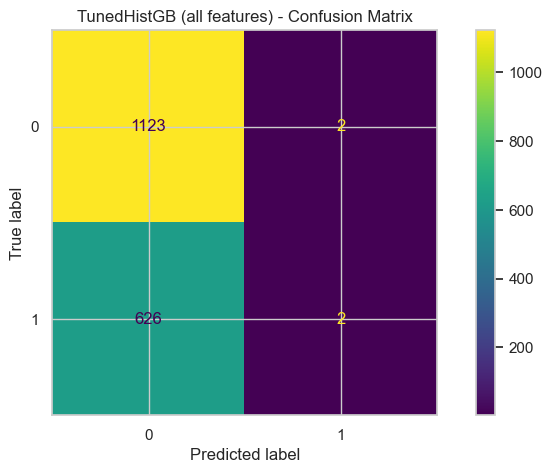

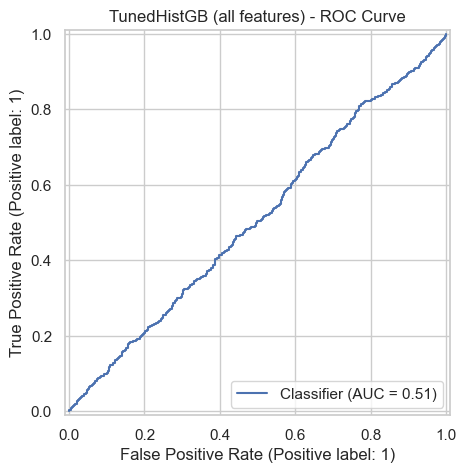

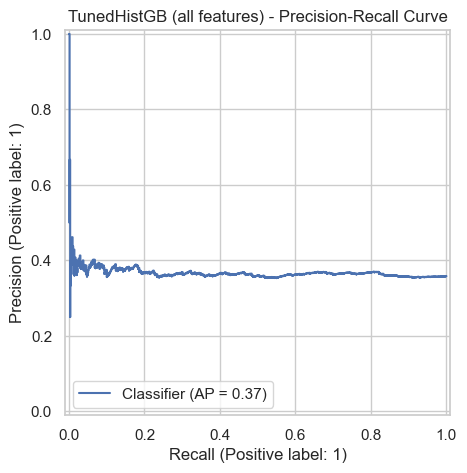

In [110]:
# Confusion matrix + curves for the FINAL chosen model
cm = confusion_matrix(y_test, final_preds)
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title(f'{final_name} - Confusion Matrix')
plt.show()

show_curves(final_name, final_proba)

## Feature Importance (Permutation)
Permutation importance is model-agnostic and works with the full preprocessing pipeline.

Age                                0.014099
Triglycerides                      0.008239
Heart Rate                         0.007480
BP_Systolic                        0.005057
Income                             0.002177
Physical Activity Days Per Week    0.002002
Previous Heart Problems            0.001657
Cholesterol                        0.001403
Alcohol Consumption                0.001377
Obesity                            0.000853
Sex                                0.000813
Stress Level                       0.000708
Sedentary Hours Per Day            0.000670
Family History                     0.000385
Diabetes                           0.000156
Diet                               0.000069
Continent                          0.000012
Smoking                            0.000000
Medication Use                    -0.000138
Sleep Hours Per Day               -0.000362
Hemisphere                        -0.000363
BP_Diastolic                      -0.001577
Exercise Hours Per Week         

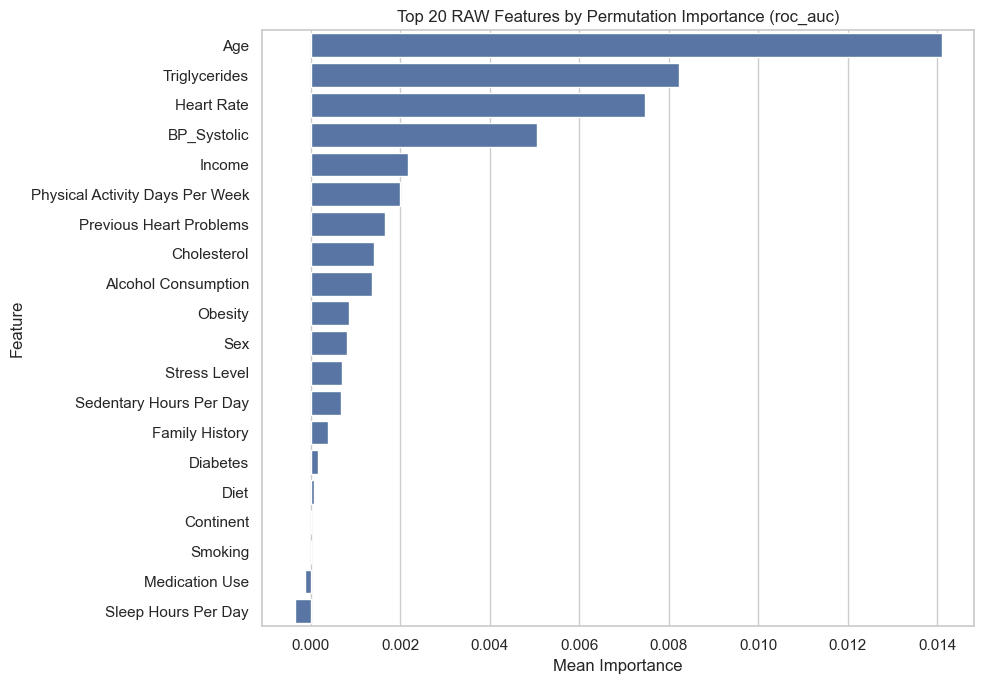

num__Age                                0.014099
num__Triglycerides                      0.008239
num__Heart Rate                         0.007480
num__BP_Systolic                        0.005057
cat__Country_Nigeria                    0.002323
num__Income                             0.002177
num__Physical Activity Days Per Week    0.002002
num__Previous Heart Problems            0.001657
num__Cholesterol                        0.001403
num__Alcohol Consumption                0.001377
cat__Country_India                      0.001367
num__Obesity                            0.000853
num__Stress Level                       0.000708
cat__Sex_Female                         0.000674
num__Sedentary Hours Per Day            0.000670
cat__Country_China                      0.000435
cat__Diet_Healthy                       0.000387
num__Family History                     0.000385
num__Diabetes                           0.000156
cat__Country_Japan                      0.000144
cat__Sex_Male       

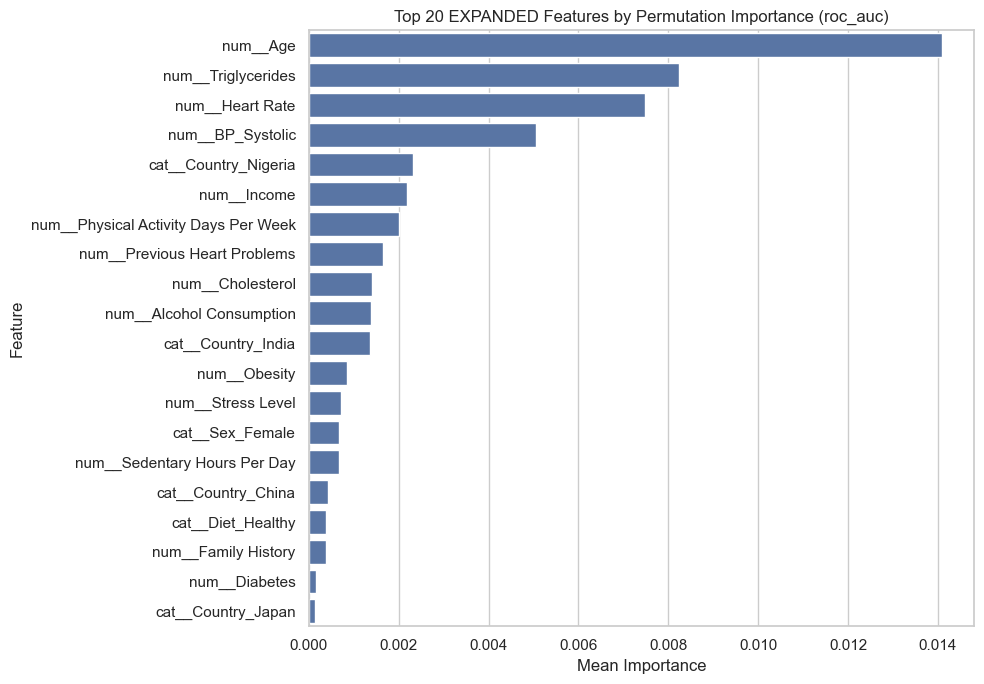

In [111]:
# Permutation importance (2 views) for the FINAL chosen model:
# 1) Raw-feature importance: permutes original input columns (X_test columns)
# 2) One-hot expanded importance: permutes post-preprocessing columns

scoring = 'roc_auc' if final_proba is not None else 'f1'

# --- 1) Raw-feature permutation importance ---
pi_raw = permutation_importance(
    final_pipe, X_test, y_test, n_repeats=10, random_state=42, scoring=scoring
)
raw_feature_names = X_test.columns.to_numpy()
raw_imp = pd.Series(pi_raw.importances_mean, index=raw_feature_names).sort_values(ascending=False)
display(raw_imp.head(25))

plt.figure(figsize=(10, 7))
sns.barplot(x=raw_imp.head(20).values, y=raw_imp.head(20).index)
plt.title(f'Top 20 RAW Features by Permutation Importance ({scoring})')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- 2) One-hot expanded permutation importance (more granular) ---
pre = final_pipe.named_steps['preprocess']
model = final_pipe.named_steps['model']
Xt_test = pre.transform(X_test)

if hasattr(pre, 'get_feature_names_out'):
    expanded_feature_names = pre.get_feature_names_out()
else:
    expanded_feature_names = np.array([f'feature_{i}' for i in range(Xt_test.shape[1])])

pi_expanded = permutation_importance(
    model, Xt_test, y_test, n_repeats=10, random_state=42, scoring=scoring
)

expanded_imp = pd.Series(pi_expanded.importances_mean, index=expanded_feature_names).sort_values(ascending=False)
display(expanded_imp.head(25))

plt.figure(figsize=(10, 7))
sns.barplot(x=expanded_imp.head(20).values, y=expanded_imp.head(20).index)
plt.title(f'Top 20 EXPANDED Features by Permutation Importance ({scoring})')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Save Best Pipeline
Exports preprocessing + model together so you can later load it and predict on raw rows.

In [112]:
ARTIFACT_PATH = 'heart_attack_risk_best_pipeline.joblib'
joblib.dump(final_pipe, ARTIFACT_PATH)
print('Saved:', ARTIFACT_PATH, '| model:', final_name)

Saved: heart_attack_risk_best_pipeline.joblib | model: TunedHistGB (all features)
